---
---

<h1 style="text-align: center; line-height: 1.2; margin-bottom: 0;">Data-Driven Diagnosis:</h1>
<h2 style="text-align: center; margin-top: 0;">Machine Learning for Early Diabetes Detection</h2>

---
---

In [1]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Set a global random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Show all columns
pd.set_option("display.max_columns", None)

# Notes

**About the ZIP-file:**

Two plots generated in this notebook are written to the folder "plots", as they are read in again later on. I did not name the folder "resources" because it could be misleading, as these images are my own plots and not external ones.

**Synonyms Used in This Notebook:**
- entry = record = row
- columns = features
- target = label

## Task 1 - The Context

### 1. Scenario 

As a data scientist working at a regional public health research institute, I've noticed a gap between diabetes prevalence and timely diagnosis, particularly in underserved communities. Many individuals are unaware of their condition until symptoms become severe, resulting in higher rates of complications and costly late-stage treatments. I believe we can help address this issue by developing a predictive model that flags individuals at higher risk based on routinely collected health and lifestyle information.

To support this idea, I built up a machine learning model that estimates a person's likelihood of having diabetes or prediabetes, using features such as BMI, blood pressure, physical activity, diet, smoking status, and access to healthcare. This model could be integrated into health screening programs, mobile apps, or educational campaigns to prioritize follow-up and early intervention in population-wide settings.

For this project I use the Diabetes Health Indicators dataset by the CDC (Centers for Disease Control and Prevention). This dataset is derived from the Behavioral Risk Factor Surveillance System (BRFSS 2015), which is a large health survey conducted across the U.S. every year. It contains responses from over 400,000 Americans on health-related risk behaviors, chronic health conditions, and the use of preventative services and has been conducted every year since 1984.

However I used a subset of the dataset, which still contains responses from more than 70,000 individuals. The reason is that the original datset is imbalanced. Using a balanced subset ensures dealing with a 50/50 split between diabetes-positive and diabetes-negative cases, so the model does not become biased toward any class.

The target label is based on self-reported diagnosis of diabetes or prediabetes. This might not be clinically verified, however it reflects the real-world uncertainty that screening tools must deal with in public health settings. So the goal is **not** a formal diagnosis, but an early and cost-effective risk identification across large and diverse populations.
Demonstrating the model's performance on this dataset should show how it can contribute to better and earlier diabetes diagnosis.

### 2. Value of Solving the Problem

Diabetes is one of the most prevalent chronic diseases in the U.S., affecting over 34 million people with an additional 88 million living with prediabetes. But the CDC estimates that 1 in 5 diabetics, and roughly 8 in 10 prediabetics are unaware of their risk. This contributes to delayed treatment, reduced quality of life, and complications like heart disease, kidney failure, and amputations. There are also economic aspects, with estimated annual costs exceeding $400 billion (!) when including undiagnosed and prediabetic cases.

Early identification through low-cost risk models can lead to preventive care, lifestyle changes, and targeted education. This would help to reduce both health and financial burdens significantly.

A predictive model adds value by:
- Helping public health agencies flag individuals at risk who might not otherwise seek care
- Supporting more efficient resource allocation for prevention programs
- Providing insight into social and behavioral factors that correlate with diabetes risk

The dataset used in this project, derived from the CDC's BRFSS 2015 survey, captures those factors (income, education, smoking, diet, etc.). Therefore it's ideally suited for population-level modeling and outreach planning.

### 3. Quality Criteria for Model Evaluation

To evaluate the model, I will use the following two metrics:

**Recall (Sensitivity):**
  In medical diagnostics, false negatives can be dangerous. Recall ensures that as many patients with diabetes as possible are identified, reducing the risk of missed cases.


**AUC-ROC (Area Under the ROC Curve):**
  This metric provides an overall measure of the model's ability to distinguish between positive and negative cases across all classification thresholds. The ROC curve itself plots the true positive rate against the false positive rate, and the AUC condenses this into a single value between 0 and 1. This metric is especially important when dealing with imbalanced class distributions, as it reflects the model's discriminative power more comprehensively than accuracy alone.

These metrics together support a balanced evaluation, because recall focuses on both medical safety and AUC-ROC focuses on robust model performance.

## Task 2 - The Data

### Description of the Dataset

For this project I use a Diabetes Health Indicators dataset, which is based on responses to the 2015 Behavioral Risk Factor Surveillance System (BRFSS), an annual health-related survey conducted by the Centers for Disease Control and Prevention (CDC). The BRFSS collects data on health behaviors, chronic conditions, and preventive services from over 400,000 Americans each year via telephone interviews. It has been conducted continuously since 1984 and is one of the world’s largest ongoing health surveys.

The specific version used here is a cleaned and balanced subset of the original dataset, provided by Alex Teboul on Kaggle (link at the end of this cell). He also provides links to original the original raw dataset by CDC and the cleaning notebook. The cleaned version used in this project has been filtered and restructured. It still includes more than 70,000 survey responses on 21 selected variables and a balanced target variable for binary diabetes prediction. For convenience I provide the file in the data folder under the name `diabetes_binary_5050split_health_indicators_BRFSS2015.csv`, so you do not must sign up to Kaggle.

Each row in the dataset represents a single participant's responses and the 21 feature variables are related to physical health, behavior, demographics, and access to care, along with a binary target variable `Diabetes_binary`. A detailed overview and explanation of the features is shown in the next cell.

This dataset is suitable for the project because:
- It is derived from an extensive real-world survey, containing more than 70,000 entries.
- It offers a rich set of 21 behavioral and lifestyle features that are relevant for predicting the final target.
- There are no missing values, making preprocessing easier.
- The dataset is already balanced, which allows for fair model evaluation without requiring synthetic oversampling or undersampling.

**Link to dataset:**

https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data?select=diabetes_binary_5050split_health_indicators_BRFSS2015.csv 

(there are 3 CSV files, the relevant on is `diabetes_binary_5050split_health_indicators_BRFSS2015.csv`)

---

### All features, feature types, and their respective meaning:

**Note:** All features are technically loaded as float64 due to CSV formatting (more on that in task 3). However, the semantic types shown here (e.g., binary, ordinal, continuous) more accurately reflect the real nature of each feature. For some of the features there are additonal notes at the end, for which you might have a look into the codebook (`codebook15_llcp.pdf`). This codebook is also contained in the data folder. 

| Feature                  | Type (Semantic)    |Explanation                                                           |
|--------------------------|--------------------|----------------------------------------------------------------------|
| Diabetes_binary (target) | Binary (0/1)       | 0 = no diabetes, 1 = prediabetes or diabetes                         |
| HighBP                   | Binary (0/1)       | High blood pressure: 0 = no, 1 = yes                                 |
| HighChol                 | Binary (0/1)       | High cholesterol level: 0 = no, 1 = yes                              |
| CholCheck                | Binary (0/1)       | Cholesterol check in last 5 years: 0 = no, 1 = yes                   |
| BMI                      | Continuous (float) | Body Mass Index                                                      |
| Smoker                   | Binary (0/1)       | Smoked ≥100 cigarettes in lifetime: 0 = no, 1 = yes                  |
| Stroke                   | Binary (0/1)       | Ever told you had a stroke: 0 = no, 1 = yes                          |
| HeartDiseaseorAttack     | Binary (0/1)       | CHD or myocardial infarction: 0 = no, 1 = yes                        |
| PhysActivity             | Binary (0/1)       | Physical activity in past 30 days (not job-related): 0 = no, 1 = yes |
| Fruits                   | Binary (0/1)       | Consume fruit ≥1 times per day: 0 = no, 1 = yes                      |
| Veggies                  | Binary (0/1)       | Consume vegetables ≥1 times per day: 0 = no, 1 = yes                 |
| HvyAlcoholConsump        | Binary (0/1)       | Heavy alcohol consumption: 0 = no, 1 = yes                           |
| AnyHealthcare            | Binary (0/1)       | Any kind of health care coverage: 0 = no, 1 = yes                    |
| NoDocbcCost              | Binary (0/1)       | Couldn’t see doctor due to cost in past 12 months: 0 = no, 1 = yes   |
| GenHlth<sup>1            | Ordinal (1–5)      | General health: <br> 1 = Excellent <br> 2 = Very good <br> 3 = Good <br> 4 = Fair <br> 5 = Poor                                                                                            |
| MentHlth                 | Count (0–30)       | Number of days mental health not good in the past 30 days            |
| PhysHlth                 | Count (0–30)       | Number of days physical health not good in the past 30 days                       |
| DiffWalk                 | Binary (0/1)       | Serious difficulty walking/climbing stairs: 0 = no, 1 = yes          | 
| Sex                      | Binary             | Sex: 0 = female, 1 = male                                            |
| Age<sup>2                | Ordinal (1–13)     | Age categories (Age in years): <br> 1 = 18–24 <br> 2 = 25-29 <br> 3 = 30-34 <br> 4 = 35-39 <br> 5 = 40-44 <br> 6 = 45-49 <br> 7 = 50-54 <br> 8 = 55-59 <br> 9 = 60-64 <br> 10 = 65-69 <br> 11 = 70-74 <br> 12 = 75-79 <br> 13 = 80 or older                                                                            |
| Education<sup>3          | Ordinal (1–6)      | Education level: <br> 1 = Never attended school or only kindergarten <br> 2 = Grades 1 through 8 (Elementary) <br> 3 = Grades 9 through 11 (Some high school) <br> 4 = Grade 12 or GED (High school graduate) <br> 5 = College 1 year to 3 years (Some college or technical school) <br> 6 = College 4 years or more (College graduate)                                                                                                     |
| Income<sup>4             | Ordinal (1–8)      | Income level in US$: <br> 1 = <10,000 <br> 2 = 10,000-14,999 <br> 3 = 15,000-19,999 <br> 4 = 20,000-24,999 <br> 5 = 25,000-34,999 <br> 6 = 35,000-49,999 <br> 7 = 50,000-74,999 <br> 8 = ≥75,000                                                                                                                    |

**<sup>1** Also see SAS Variable Name "GENHLTH" in the codebook. In the codebook there there are also the groups 7 = Don't know/Not sure, 9 = Refused, BLANK = Not asked or Missing, but these groups are not present in my dataset version.

**<sup>2** All age categories are in closed intervalse.g. for category 2: 25 ≤ age in years ≤ 29. Also see SAS Variable Name "_AGEG5YR" in the codebook. In the codebook there is also a group 14 = Don't know/Refused/Missing, but this group is not present in my dataset version.

**<sup>3** Also see SAS Variable Name "EDUCA" in the codebook. In the codebook there is also a group 9 = Refused, but this group is not present in my dataset version.

**<sup>4** Also see SAS Variable Name "INCOME2" in the codebook. In the codebook there are also the groups 77 = Don't know/Not sure, 99 = Refused, BLANK = Not asked or Missing, but these groups are not present in my dataset version.

---

### Load and present the dataset

In [2]:
raw_data = pd.read_csv("data/diabetes_raw_50_50_data.csv", header=0)
raw_data.head(5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


## Task 3 - Initial Data Analysis

### Basic infos of the dataset

The following cells and outputs should give an overview of the dataset, e.g. the number of rows, columns, missing values, data types, and unique values in each column.

1. Show shape of the dataset:

In [3]:
raw_data.shape

(70692, 22)

$\Rightarrow$ The raw dataset contains 70692 rows and 22 columns

2. Get more datailed information, e.g. count of missing values and data type for each column:

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

$\Rightarrow$ As mentioned before, no missing values and all features are technically of data type float64

3. Show how many unique values there are for each feature:

In [5]:
raw_data.nunique()

Diabetes_binary          2
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     80
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

**Observations:** 
- Many features just have 2 unique values because they are binary or they just have 2 possible groups (like `Sex`)
- `BMI` has most unique values as it's the only continous feature
- `GenHlth`, `MentHlth`, `PhysHlth`, `Age`, `Education`, and `Income` cover all possible values/groups

4. Validate that the dataset is indeed balanced, meaning that the final classes are represented in equal proportions:

In [6]:
raw_data.Diabetes_binary.value_counts()

Diabetes_binary
0.0    35346
1.0    35346
Name: count, dtype: int64

$\Rightarrow$ Both classes are represented equally as we the dataset contains 50% of class 0 (no diabetes) and 50% of class 1 (prediabetes or diabetes)

5. Check duplicate rows:

In [7]:
num_duplicate_rows = raw_data.duplicated().sum().item()
print("Number of duplicate rows:", num_duplicate_rows)
percentage_duplicate_rows = 100 * num_duplicate_rows/len(raw_data)
print(f"Percentage of duplicate rows in the whole dataset: {round(percentage_duplicate_rows,2)}%")

Number of duplicate rows: 1635
Percentage of duplicate rows in the whole dataset: 2.31%


$\Rightarrow$ Technically there are 1635 duplicate rows in the dataset, but it is not necessary to remove as these could be people whith the same values. As many features are binary or ordinal this is not unlikely and can happen in any survey.

## Task 4 - EDA and Preprocessing

### 4.1 Exploratory Data Analysis of the original (untransformed) data

1. Get an overview of the main statistical properties of each feature:

In [8]:
raw_data.describe().round(2)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,70692.0,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00,70692.00
mean,0.5,0.56,0.53,0.98,29.86,0.48,0.06,0.15,0.70,0.61,0.79,0.04,0.95,0.09,2.84,3.75,5.81,0.25,0.46,8.58,4.92,5.70
std,0.5,0.50,0.50,0.16,7.11,0.50,0.24,0.35,0.46,0.49,0.41,0.20,0.21,0.29,1.11,8.16,10.06,0.43,0.50,2.85,1.03,2.18
min,0.0,0.00,0.00,0.00,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
25%,0.0,0.00,0.00,1.00,25.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,2.00,0.00,0.00,0.00,0.00,7.00,4.00,4.00
50%,0.5,1.00,1.00,1.00,29.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,3.00,0.00,0.00,0.00,0.00,9.00,5.00,6.00
75%,1.0,1.00,1.00,1.00,33.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,4.00,2.00,6.00,1.00,1.00,11.00,6.00,8.00
max,1.0,1.00,1.00,1.00,98.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5.00,30.00,30.00,1.00,1.00,13.00,6.00,8.00


$\Rightarrow$ Some notable mentions:
- Average BMI of 29.86 is really high, as 25 - 29.9 is overweight and 30 - 34.9 is obesity degree 1 (!)
- Mean of general health `GenHlth` is ≈ 2.84, so in average people say they feel healthy (see groups in table)
- However 25% of people responded they have serious difficulty walking or climbing stairs (`DiffWalk`)
- Average of Sex is ≈ 0.46, indicating more females than males in the dataset 
- Mean age of 8.58 (see groups in table) indicating that the dataset skews toward older age groups (people in their late 50s to early 60s)

2. Compute correlation coefficient between the target `Diabetes_binary` and each feature, and sort by highest values:

In [9]:
raw_data.corr()["Diabetes_binary"].sort_values(ascending=False) # no need for numeric_only=True in corr(): all float64

Diabetes_binary         1.000000
GenHlth                 0.407612
HighBP                  0.381516
BMI                     0.293373
HighChol                0.289213
Age                     0.278738
DiffWalk                0.272646
PhysHlth                0.213081
HeartDiseaseorAttack    0.211523
Stroke                  0.125427
CholCheck               0.115382
MentHlth                0.087029
Smoker                  0.085999
Sex                     0.044413
NoDocbcCost             0.040977
AnyHealthcare           0.023191
Fruits                 -0.054077
Veggies                -0.079293
HvyAlcoholConsump      -0.094853
PhysActivity           -0.158666
Education              -0.170481
Income                 -0.224449
Name: Diabetes_binary, dtype: float64

**Observations**:
- No strong correlations, as all features have somewhat weak correlation with `Diabetes_binary`: |r| < 0.5
- Most positively correlated features with diabetes: `GenHlth` and `HighBP` 
- Most negatively correlated features: `Income` and `Education` (interesting, more indirect factors)

$\Rightarrow$ Diabetes is likely influenced by multiple weakly related factors rather than any single strong predictor

3. Show boxplots for the most positively (`GenHlth`) and most negatively (`Income`) correlated feature **grouped by diabetes label**:

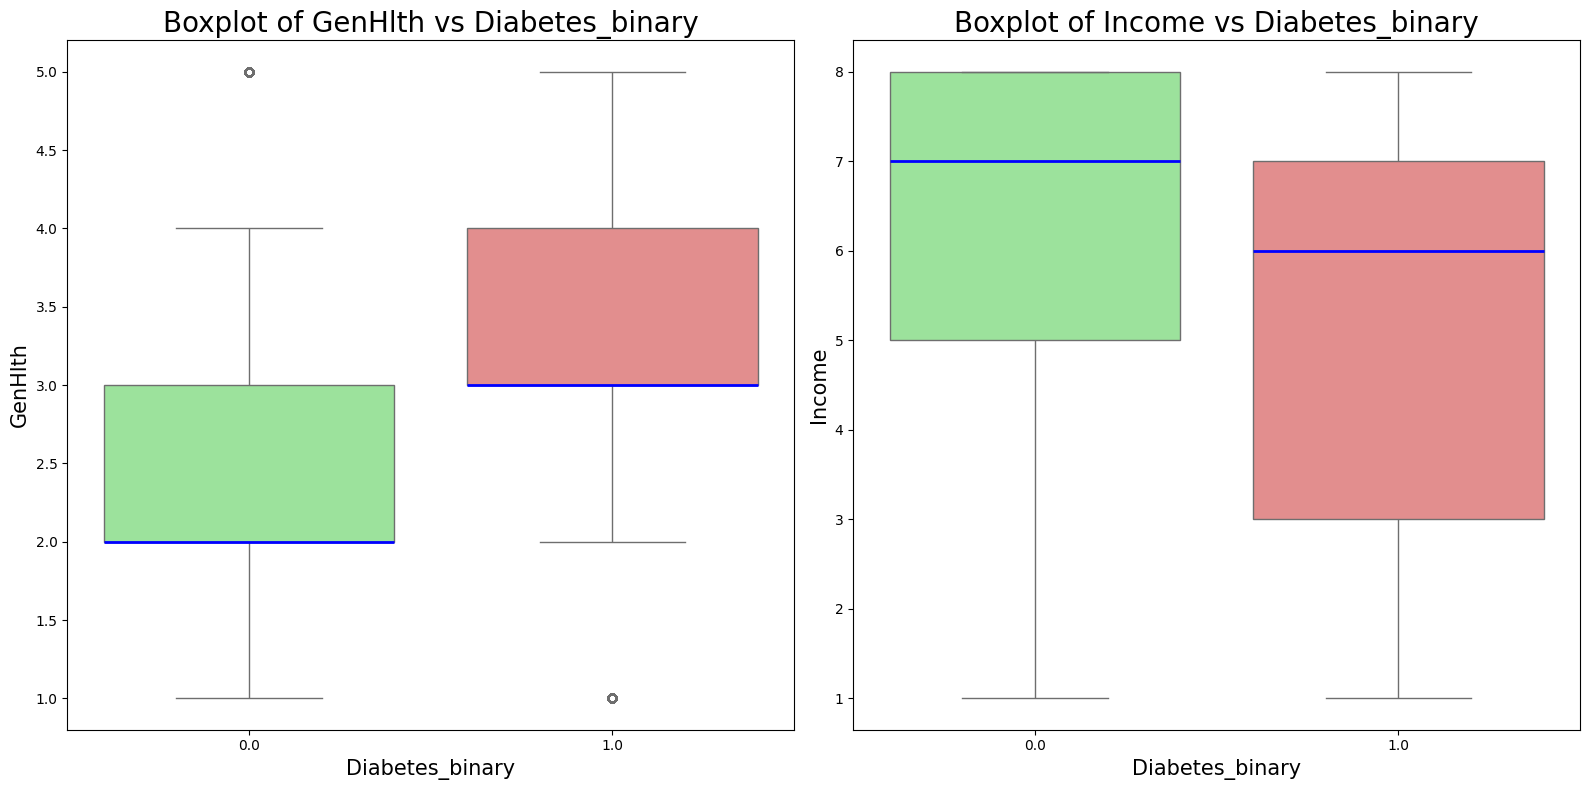

In [10]:
# Select features to plot against `Diabetes_binary`
top_positive = ["GenHlth"]
top_negative = ["Income"]
features_to_plot = top_positive + top_negative

# Set colors for boxplots
custom_palette = {0: "lightgreen", 1: "lightcoral"}
median_line = dict(color="blue", linewidth=2)

# Set up the plots
plt.figure(figsize=(16, 8))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x="Diabetes_binary",
                y=feature,
                data=raw_data,
                hue="Diabetes_binary",
                palette=custom_palette,
                medianprops=median_line,
                legend=False)
    plt.title(f"Boxplot of {feature} vs Diabetes_binary", fontdict={"fontsize":20})
    plt.xlabel("Diabetes_binary", fontdict={"fontsize":15})
    plt.ylabel(f"{feature}", fontdict={"fontsize":15})
plt.tight_layout()
plt.show()

**Observations and Interpretation:**

| <div align="center">**GenHlth vs. Diabetes_binary**</div> | <div align="center">**Income vs. Diabetes_binary**</div> |
|------------------------------------------------------------|-----------------------------------------------------------|
| <ul> <li>People with prediabetes/diabetes (Diabetes_binary = 1) tend to report worse general health (1 = excellent to 5 = poor)</li> <li>Their median GenHlth is higher (3) than those without diabetes (2)</li> <li>The interquartile range (IQR) also shifts upward, indicating more individuals with prediabetes/diabetes rate their health worse than individuals without diabetes</li> <li><strong>⇒</strong> This aligns with expectations: diabetes seems to correlate with poorer self-rated health</li> </ul> | <ul> <li>Lower income is correlated with higher diabetes prevalence</li> <li>Median income category is lower for people with prediabetes/diabetes than for those without</li> <li>The distribution for Diabetes_binary = 1 is left-shifted, meaning more prediabetic/diabetic individuals fall into lower income categories</li> <li><strong>⇒</strong> This could suggest a socioeconomic aspect: lower income levels are associated with higher diabetes risk</li> </ul> |


### 4.2 Preprocessing and Transformation discussion 

1. How to handle missing values?

    Answer: There are no missing values, so no need for action!

2. Should we reduce the dataset?

Answer: Yes, because SVM will be one of the used algorithms for this project (more on that in task 5). The runtime on the current dataset version could take hours, which is too long. Therefore `raw_data` will be reduced to 1,0000 instances and stored as `data`. This is done in the following code cell: 

In [11]:
# Reduce `raw_data` to 1,000 instances and store the result in `data`
data, _ = train_test_split(raw_data, train_size=1000, stratify=raw_data["Diabetes_binary"], random_state=RANDOM_SEED)
data.reset_index(inplace=True, drop=True) # Reset index and drop the old index which would become a column
data

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,0.0,0.0,1.0,37.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,5.0,12.0,1.0,0.0,12.0,5.0,4.0
1,1.0,0.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,5.0,2.0,0.0,1.0,7.0,6.0,5.0
2,1.0,0.0,0.0,1.0,29.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,11.0,6.0,8.0
3,0.0,1.0,1.0,1.0,23.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,30.0,30.0,1.0,0.0,10.0,5.0,1.0
4,0.0,1.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,11.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,1.0,29.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,0.0,4.0,6.0,8.0
996,0.0,0.0,1.0,1.0,41.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,15.0,25.0,1.0,0.0,7.0,4.0,7.0
997,1.0,1.0,1.0,1.0,30.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,15.0,30.0,0.0,0.0,8.0,6.0,8.0
998,1.0,1.0,1.0,1.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,8.0,5.0,8.0


3. Should any feature(s) be dropped? 

Answer: After inspecting the dataset and performing initial data analysis, I decided to not drop any feature. Even if some features (such as fruit/vegetable consumption or healthcare access) may not have any correlation with the target individually, they could contribute important context when combined with other features in multivariate models.
In medical applications, keeping a broad set of health indicators can improve model interpretability and allow for better insights (more on that will be discussed in feature importance in Task 7).

$\Rightarrow$ Therefore we keep all features!

4. Should we scale the data?

Answer: Yes, some features (e.g., `BMI`, `Age`, `MentHlth`) are numerical and require scaling for certain algorithms like SVM, **however** scaling is not applied yet in this task. This is because scaling must be done within the cross-validation or training pipeline to prevent data leakage. Therefore, feature scaling will be included later, within model-specific pipelines in Tasks 5 and 6.

### 4.3 Properties of the final reduced dataset `data`, which will be used for the following tasks

In [12]:
# Show shape of `data`
print("Shape of `data`:", data.shape)

Shape of `data`: (1000, 22)


In [13]:
# Proof that there is still a 50/50 split of class labels
print("Count class labels for target feature in `data`:")
data.Diabetes_binary.value_counts()

Count class labels for target feature in `data`:


Diabetes_binary
1.0    500
0.0    500
Name: count, dtype: int64

In [14]:
# Number of unique values for each feature of `data` after preprocessing
print("Number of unique values for each feature of `data`:")
data.nunique()

Number of unique values for each feature of `data`:


Diabetes_binary          2
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     45
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                20
PhysHlth                22
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

In [15]:
# Basic statistics for each feature of `data` after preprocessing
print("Basic statistics for each feature of `data`:")
data.describe().round(2)

Basic statistics for each feature of `data`:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,1000.0,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,0.5,0.57,0.52,0.98,29.67,0.46,0.06,0.16,0.69,0.59,0.77,0.04,0.96,0.09,2.79,3.57,5.39,0.23,0.47,8.72,4.90,5.68
std,0.5,0.50,0.50,0.15,7.01,0.50,0.23,0.36,0.46,0.49,0.42,0.20,0.19,0.29,1.08,7.95,9.83,0.42,0.50,2.81,1.05,2.15
min,0.0,0.00,0.00,0.00,14.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00
25%,0.0,0.00,0.00,1.00,25.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,2.00,0.00,0.00,0.00,0.00,7.00,4.00,4.00
50%,0.5,1.00,1.00,1.00,28.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,3.00,0.00,0.00,0.00,0.00,9.00,5.00,6.00
75%,1.0,1.00,1.00,1.00,33.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,3.00,2.00,5.00,0.00,1.00,11.00,6.00,8.00
max,1.0,1.00,1.00,1.00,73.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5.00,30.00,30.00,1.00,1.00,13.00,6.00,8.00


Finally, before moving on to the next task, I will write the subsampled dataframe to a new CSV file with the name `diabetes_subsampled_50_50_data.csv`. You can find this file in the `data` folder as well.

In [16]:
data.to_csv("data/diabetes_subsampled_50_50_data.csv", sep=",", header=True, index=False)

## Task 5 - First Impressions

### Step 1: Baseline Model and Choice of Algorithms

Before training machine learning models, we define a simple baseline **B**, which is the reference point. This baseline uses no learning and helps evaluating whether the actual models add value. Here the class `DummyClassifier` with the `most_frequent` strategy is used, which means the model always predicts the majority class: in our case either class 0 or 1 (no diabetes or prediabetes/diabetes), depending on which is more common. Even though the dataset is balanced, the baseline helps interpret whether the real models (see below) are better in terms of their performances.

In a simple 80/20 stratified train-test split the baseline is evaluated using the quality criteria defined in Task 1:
- **Recall (Sensitivity):** Important for identifying individuals with diabetes or prediabetes.
- **ROC AUC:** Measures the model’s ability to rank predictions correctly across thresholds.

To build the first real models, 2 machine learning algorithms with different underlying mechanisms are applied:

- **A1: Random Forest**  
  A tree-based ensemble method that is robust, interpretable, and does not require feature scaling. It works well with both categorical and continuous variables.

- **A2: Support Vector Machine (RBF kernel)**  
  A distance-based, nonlinear algorithm that maps data into a higher-dimensional space. It requires feature scaling, and for this purpose MinMaxScaler is used, because it preserves binary feature values (already within [0, 1]) while scaling ordinal and continuous variables for use in kernel-based models.  

For each model the **same 80/20 stratified train-test split as for the simple baseline** is used, and the two quality criteria are applied for evaluation.

All of this is done in the following cell:

In [17]:
# Use the unscaled data for consistency with later models
X = data.drop(columns="Diabetes_binary")
y = data["Diabetes_binary"]

# Stratified train-test split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

# Define and fit the DummyClassifier baseline
baseline_model = DummyClassifier(strategy="most_frequent", random_state=RANDOM_SEED)
baseline_model.fit(X_train, y_train)  # here fit() does NOT train, but COUNTS the most frequent class in y_train
y_pred_baseline = baseline_model.predict(X_test)
y_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]
recall_baseline = recall_score(y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_test, y_proba_baseline)

# Fit and predict with A1: Random Forest
model_rf = RandomForestClassifier(random_state=RANDOM_SEED)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]
recall_rf = recall_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

# Fit and predict with A2: SVM with RBF kernel
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model_svm = SVC(kernel="rbf", probability=True, random_state=RANDOM_SEED)
model_svm.fit(X_train_scaled, y_train)
y_pred_svm = model_svm.predict(X_test_scaled)
y_proba_svm = model_svm.predict_proba(X_test_scaled)[:, 1]
recall_svm = recall_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_proba_svm)

# Create a dictionary of results
results = {"Model": ["Baseline", "Random Forest", "SVM"],
           "Recall_Train_Test": [recall_baseline, recall_rf, recall_svm],
           "ROC_AUC_Train_Test": [roc_auc_baseline, roc_auc_rf, roc_auc_svm]}

# Convert to DataFrame and format cells
results_df = pd.DataFrame(results)
results_df["Recall_Train_Test"] = results_df["Recall_Train_Test"].map("{:.4f}".format)
results_df["ROC_AUC_Train_Test"] = results_df["ROC_AUC_Train_Test"].map("{:.4f}".format)
results_df.set_index(keys=["Model"], drop=True, inplace=True) # Set `Model` as index, so the table looks better

print("Evaluation results on the train-test split:")
results_df

Evaluation results on the train-test split:


,Recall_Train_Test,ROC_AUC_Train_Test
Model,,
Baseline,0.0000,0.5000
Random Forest,0.7200,0.8038
SVM,0.7900,0.8171


##### Let's plot the **normalized** confusion matrices for all models. They are normalized to make them comparible to the confusion matrices which will be created with cross-validation in step 2.

In [18]:
# First a function for normalization is defined
def normalize_confusion_matrix(cm):
    return cm.astype("float") / cm.sum(axis=1, keepdims=True)

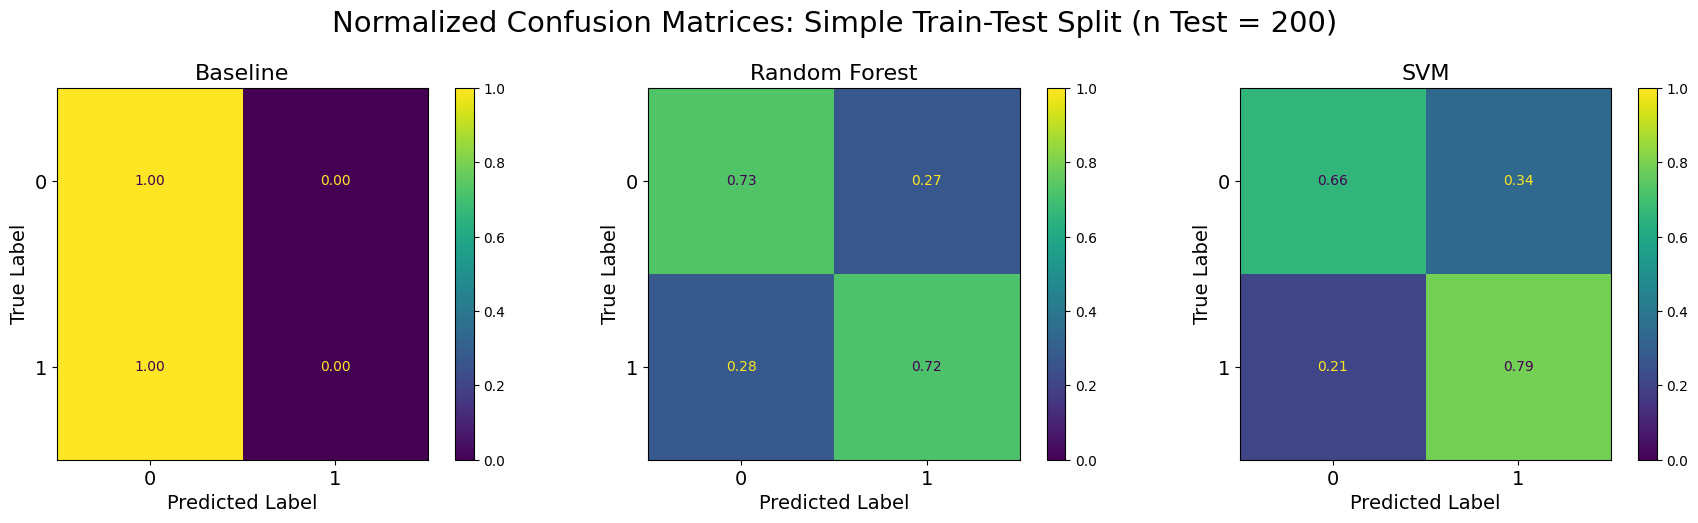

In [19]:
# Create regular confusion matrices
cm_base = confusion_matrix(y_test, y_pred_baseline)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Normalize with defined function 
cm_base_norm = normalize_confusion_matrix(cm_base)
cm_rf_norm = normalize_confusion_matrix(cm_rf)
cm_svm_norm = normalize_confusion_matrix(cm_svm)

# Create subplots for the three matrices, and prepare plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("Normalized Confusion Matrices: Simple Train-Test Split (n Test = 200)", fontsize=21)
titles = ["Baseline", "Random Forest", "SVM"]
matrices = [cm_base_norm, cm_rf_norm, cm_svm_norm]
displays = []

for ax, cm, title in zip(axes, matrices, titles):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, colorbar=True, values_format=".2f")
    ax.set_title(f"{title}", fontsize=16)
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    displays.append(disp)

# Normalize all color maps, so all matrices have the same colorbar range
for disp in displays:
    im = disp.im_
    im.set_clim(0, 1)  # Set color limits to 0–1

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("plots/Confusion_Matrices_Simple.png", dpi=300, bbox_inches="tight") # Save plot for later comparison
plt.show()

##### And now let's plot the ROC curve for all models:

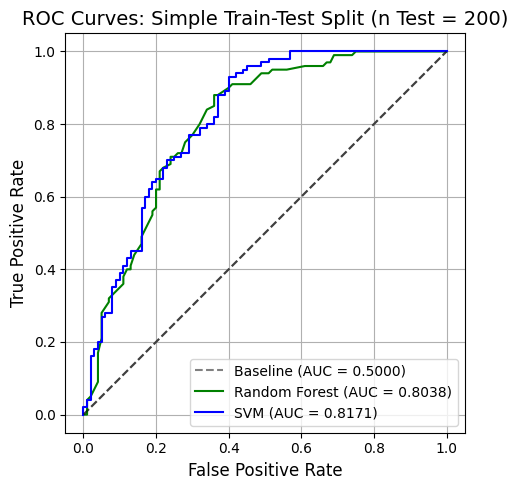

In [20]:
# Compute ROC curves
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_baseline)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)

# Plot
fig, ax = plt.subplots(figsize=(5, 5))  

ax.plot(fpr_base, tpr_base, label=f"Baseline (AUC = {roc_auc_baseline:.4f})", linestyle="--", color="gray")
ax.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})", color="green")
ax.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.4f})", color="blue")
ax.plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5)

ax.set_title("ROC Curves: Simple Train-Test Split (n Test = 200)", fontsize=14)
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.legend(loc="lower right", fontsize=10)
ax.grid(True)
ax.set_aspect("equal", adjustable="box")  
plt.tight_layout()
plt.show()

### Interpretation of the first Train-Test Evaluation Results

It seems that the baseline model always predicts the majority class 0 (no diabetes), so it fails to identify any positive cases resulting in a **recall of 0.0**. Since it assigns the same probability (0.0) to the positive class of people with prediabetes/diabetes, it cannot distinguish between classes. So it ranks the positive and negative cases equally, which leads to an **ROC AUC of 0.5**. This is the same like random guessing.

Both machine learning models outperform the baseline by a wide margin:
- **Random Forest** achieves a recall of 0.7200 and ROC AUC of 0.8038, indicating solid performance with no preprocessing
- **SVM (RBF kernel)** outperforms Random Forest with a recall of 0.7900 and ROC AUC of 0.8171, benefiting from feature scaling and its capacity to capture nonlinear relationships.

These results suggest that both models are viable, with SVM showing stronger initial performance on the train-test split. Regarding the fact that this was just a first impression, both models achieved good ROC AUC scores. However in the context of diabetes detection, improving the recall score is very important, as missing positive cases can lead to delayed diagnosis and treatment.

### Step 2: Further Evaluation with Cross Validation

To better asses the performance and stability of the two models, a simple (non-nested) cross-validation is applied. This complements the earlier train-test split by providing performance estimates averaged over multiple folds.

Therefore a **stratified 10-fold cross-validation** is used., to preserve the class balance in each fold. Stratification ensures that each fold maintains the original class distribution (diabetes vs. no diabetes). Using 10 folds should be a good balance between computational efficiency and reliable performance estimation. The evaluation still uses the same two evaluation metrics **Recall (Sensitivity)** and **ROC AUC**.

The baseline model is not included in the CV, as it does not benefit from training on different subsets and its performance is already deterministic. However, later it will also be shown in the plots for better comparison visualization.

In [21]:
# Create StratifiedKFold object
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

# Lists for both algorithms and both metrics, to collect metrics scores per fold
recall_rf_cv, recall_svm_cv = [], []    # Recall results 
roc_auc_rf_cv, roc_auc_svm_cv = [], []  # ROC AUC results

# Initial onfusion matrix totals -> aggregate confusion matrix results across folds
cm_rf_total = np.zeros((2, 2), dtype=int)   # Random forest
cm_svm_total = np.zeros((2, 2), dtype=int)  # SVM

# For ROC curves, store all out-of-fold probabilities
y_proba_rf_all = np.zeros_like(y, dtype=float)   # Random forest
y_proba_svm_all = np.zeros_like(y, dtype=float)  # SVM
 
for train_idx, test_idx in cv.split(X, y):                     # Loop over each fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]      # Split features
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]      # Split targets

    # Random Forest (= RF)
    rf = RandomForestClassifier(random_state=RANDOM_SEED)      # Initialize random forest
    rf.fit(X_train, y_train)                                   # Train random forest
    y_pred_rf = rf.predict(X_test)                             # Predict labels with random forest
    y_proba_rf = rf.predict_proba(X_test)[:, 1]                # Predict probabilities for ROC AUC
    cm_rf_total += confusion_matrix(y_test, y_pred_rf)         # Accumulate confusion matrix
    recall_rf_cv.append(recall_score(y_test, y_pred_rf))       # Store recall score
    roc_auc_rf_cv.append(roc_auc_score(y_test, y_proba_rf))    # Store ROC AUC score
    y_proba_rf_all[test_idx] = y_proba_rf                      # Store out-of-fold probabilities at correct indices

    # SVM
    svm = Pipeline([("scaler", MinMaxScaler()),                # Initialize SVM with scaling and SVC
                    ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_SEED))
                    ])
    svm.fit(X_train, y_train)                                  # Train SVM
    y_pred_svm = svm.predict(X_test)                           # Predict labels
    y_proba_svm = svm.predict_proba(X_test)[:, 1]              # Predict probabilities for ROC AUC
    cm_svm_total += confusion_matrix(y_test, y_pred_svm)       # Accumulate confusion matrix
    recall_svm_cv.append(recall_score(y_test, y_pred_svm))     # Store recall score
    roc_auc_svm_cv.append(roc_auc_score(y_test, y_proba_svm))  # Store ROC AUC score
    y_proba_svm_all[test_idx] = y_proba_svm                    # Store out-of-fold probabilities at correct indices

##### Now let's extend the previous table, so it shows the results of both steps, so the metrics evaluation for the baseline and both algorithms for the simple train-test split as well as for CV:

In [22]:
# Update results_df with Step 2 CV results
results_df.reset_index(inplace=True)    # Undo index set from step 1 for easier appending

# Recall mean results of CV 
results_df["Mean_Recall_CV"] = ["-",                         # Baseline not evaluated in CV
                                  f"{np.mean(recall_rf_cv):.4f}",     # Mean for random forest
                                  f"{np.mean(recall_svm_cv):.4f}"]    # Mean for SVM

# Recall standard deviaation results of CV 
results_df["Std_Recall_CV"] = ["-",                          # Baseline not evaluated in CV
                                 f"{np.std(recall_rf_cv):.4f}",       # Std for random forest
                                 f"{np.std(recall_svm_cv):.4f}"]      # Std for SVM
 
# ROC AUC mean results of CV 
results_df["Mean_ROC_AUC_CV"] = ["-",                        # Baseline not evaluated in CV
                                   f"{np.mean(roc_auc_rf_cv):.4f}",   # Mean for random forest
                                   f"{np.mean(roc_auc_svm_cv):.4f}"]  # Mean for SVM

# ROC AUC standard deviaation results of CV 
results_df["Std_ROC_AUC_CV"] = ["-",                         # Baseline not evaluated in CV
                                  f"{np.std(roc_auc_rf_cv):.4f}",     # Std for random forest
                                  f"{np.std(roc_auc_svm_cv):.4f}"]    # Std for SVM

# Reorder for better overview
results_task5_df = results_df[["Model",  "Recall_Train_Test", "Mean_Recall_CV", "Std_Recall_CV",
                               "ROC_AUC_Train_Test", "Mean_ROC_AUC_CV", "Std_ROC_AUC_CV"]]

# Print final comparison table
print("Comparison of Train-Test Split and Simple Cross-Validation Results:")
results_task5_df.set_index("Model", inplace=True)
results_task5_df

Comparison of Train-Test Split and Simple Cross-Validation Results:


,Recall_Train_Test,Mean_Recall_CV,Std_Recall_CV,ROC_AUC_Train_Test,Mean_ROC_AUC_CV,Std_ROC_AUC_CV
Model,,,,,,
Baseline,0.0000,-,-,0.5000,-,-
Random Forest,0.7200,0.7500,0.0647,0.8038,0.7881,0.0536
SVM,0.7900,0.7760,0.0307,0.8171,0.7984,0.0285


$\Rightarrow$ After performing cross-validation, it shows that just recall for random forest increased. For SVM it decreased, as well as the ROC AUC scores for both algorithms. However, all changes are relatively small, especially for ROC AUC. Also, standard deviations show that SVM seems to be more stable than random forest.

##### Next the confucion matrices for step 2 are calculated. As 10 folds were evaluated, each fold iteration would have its own result for the matrices. But as an "averaged" result is wanted for a comparison to step 1, here the matrices are normalized again. So now you can see the reason why the confusion matrices in step 1 were already shown as normalized versions:

In [23]:
# Normalize confusion matrices
cm_base_norm = normalize_confusion_matrix(cm_base)  
cm_rf_cv_norm = normalize_confusion_matrix(cm_rf_total)
cm_svm_cv_norm = normalize_confusion_matrix(cm_svm_total)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("Normalized Confusion Matrices: Cross-Validation (Same Baseline as Train-Test)", fontsize=21)

titles = ["Baseline", "Random Forest (CV)", "SVM (CV)"]
matrices = [cm_base_norm, cm_rf_cv_norm, cm_svm_cv_norm]
displays = []

for ax, cm, title in zip(axes, matrices, titles):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, colorbar=True, values_format=".2f")
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    displays.append(disp)

for disp in displays:
    disp.im_.set_clim(0, 1)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("plots/Confusion_Matrices_CV.png", dpi=300, bbox_inches="tight") # Save plot for comparison
plt.close()

##### Let's comare the **normalized** confusion matrices of step 1 with the results of step 2. Note that the Baseline is the same in both step, as it is not calculated but a heuristic:

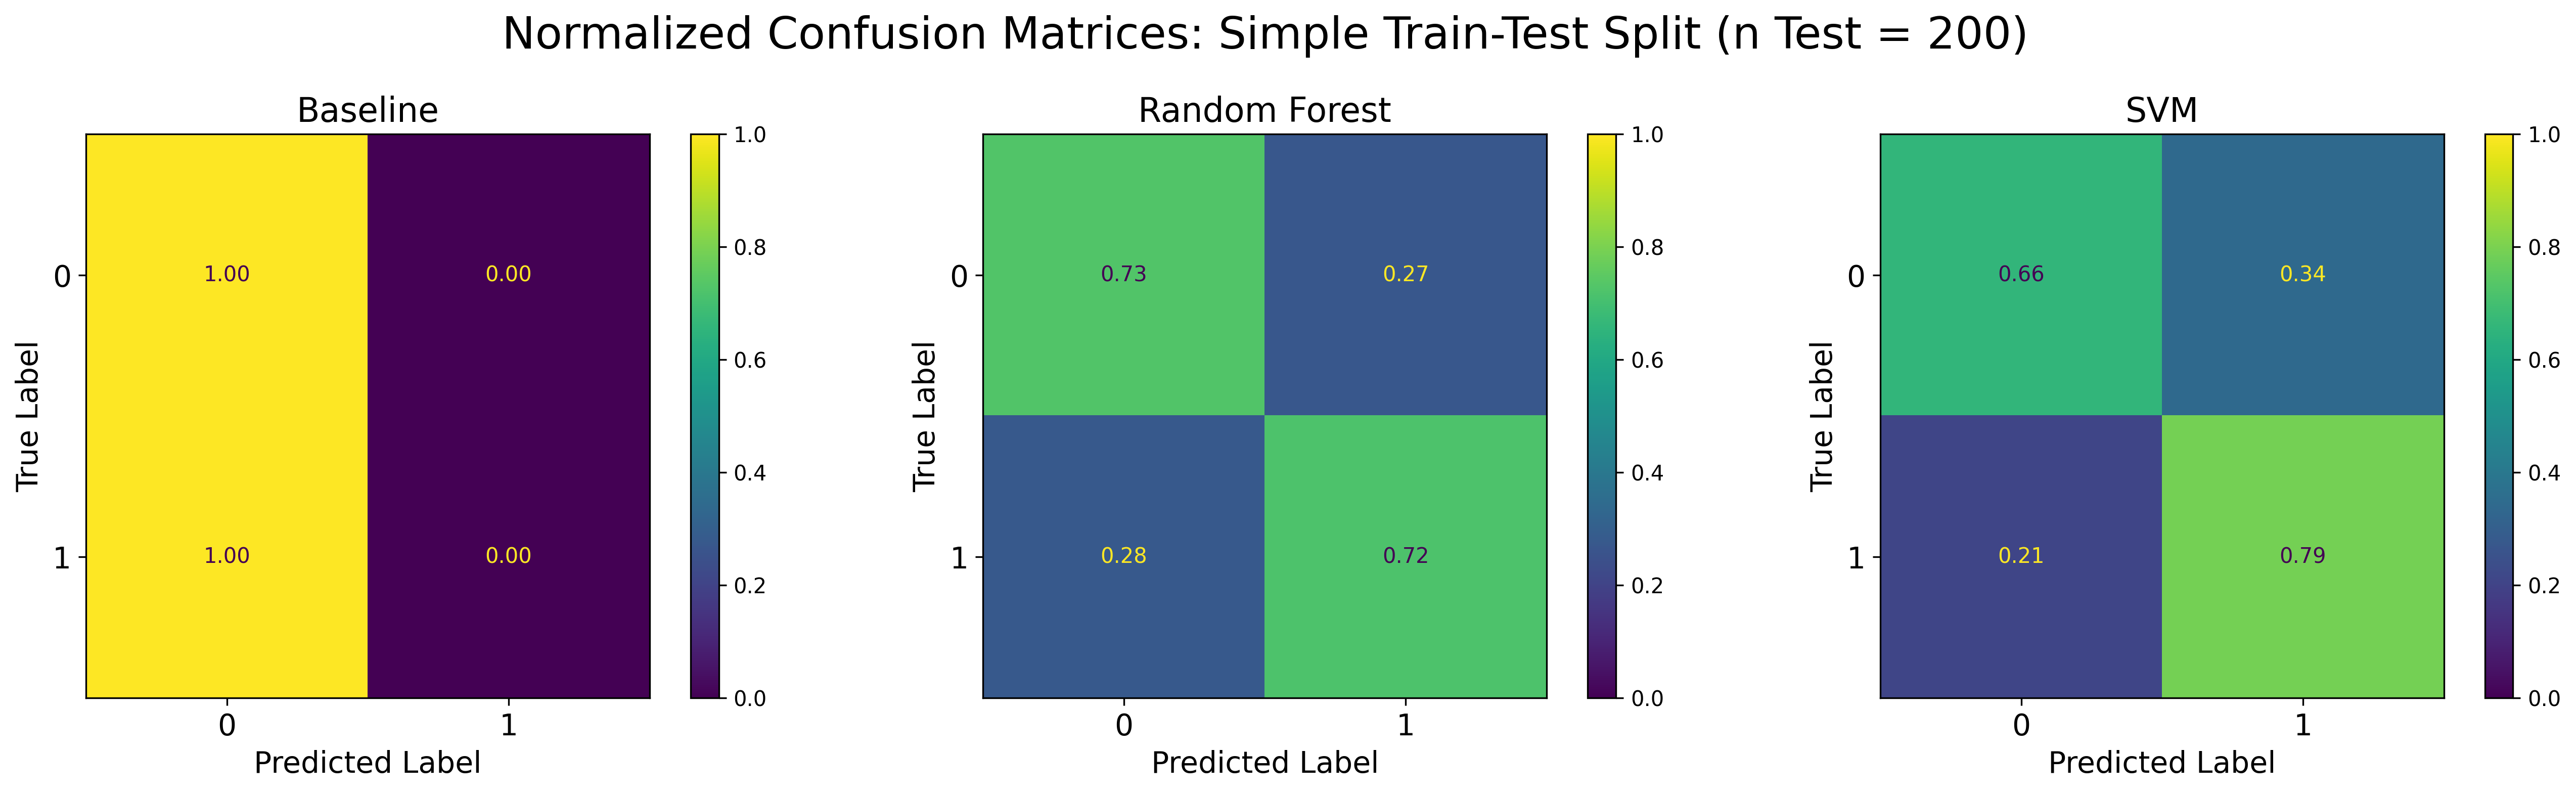

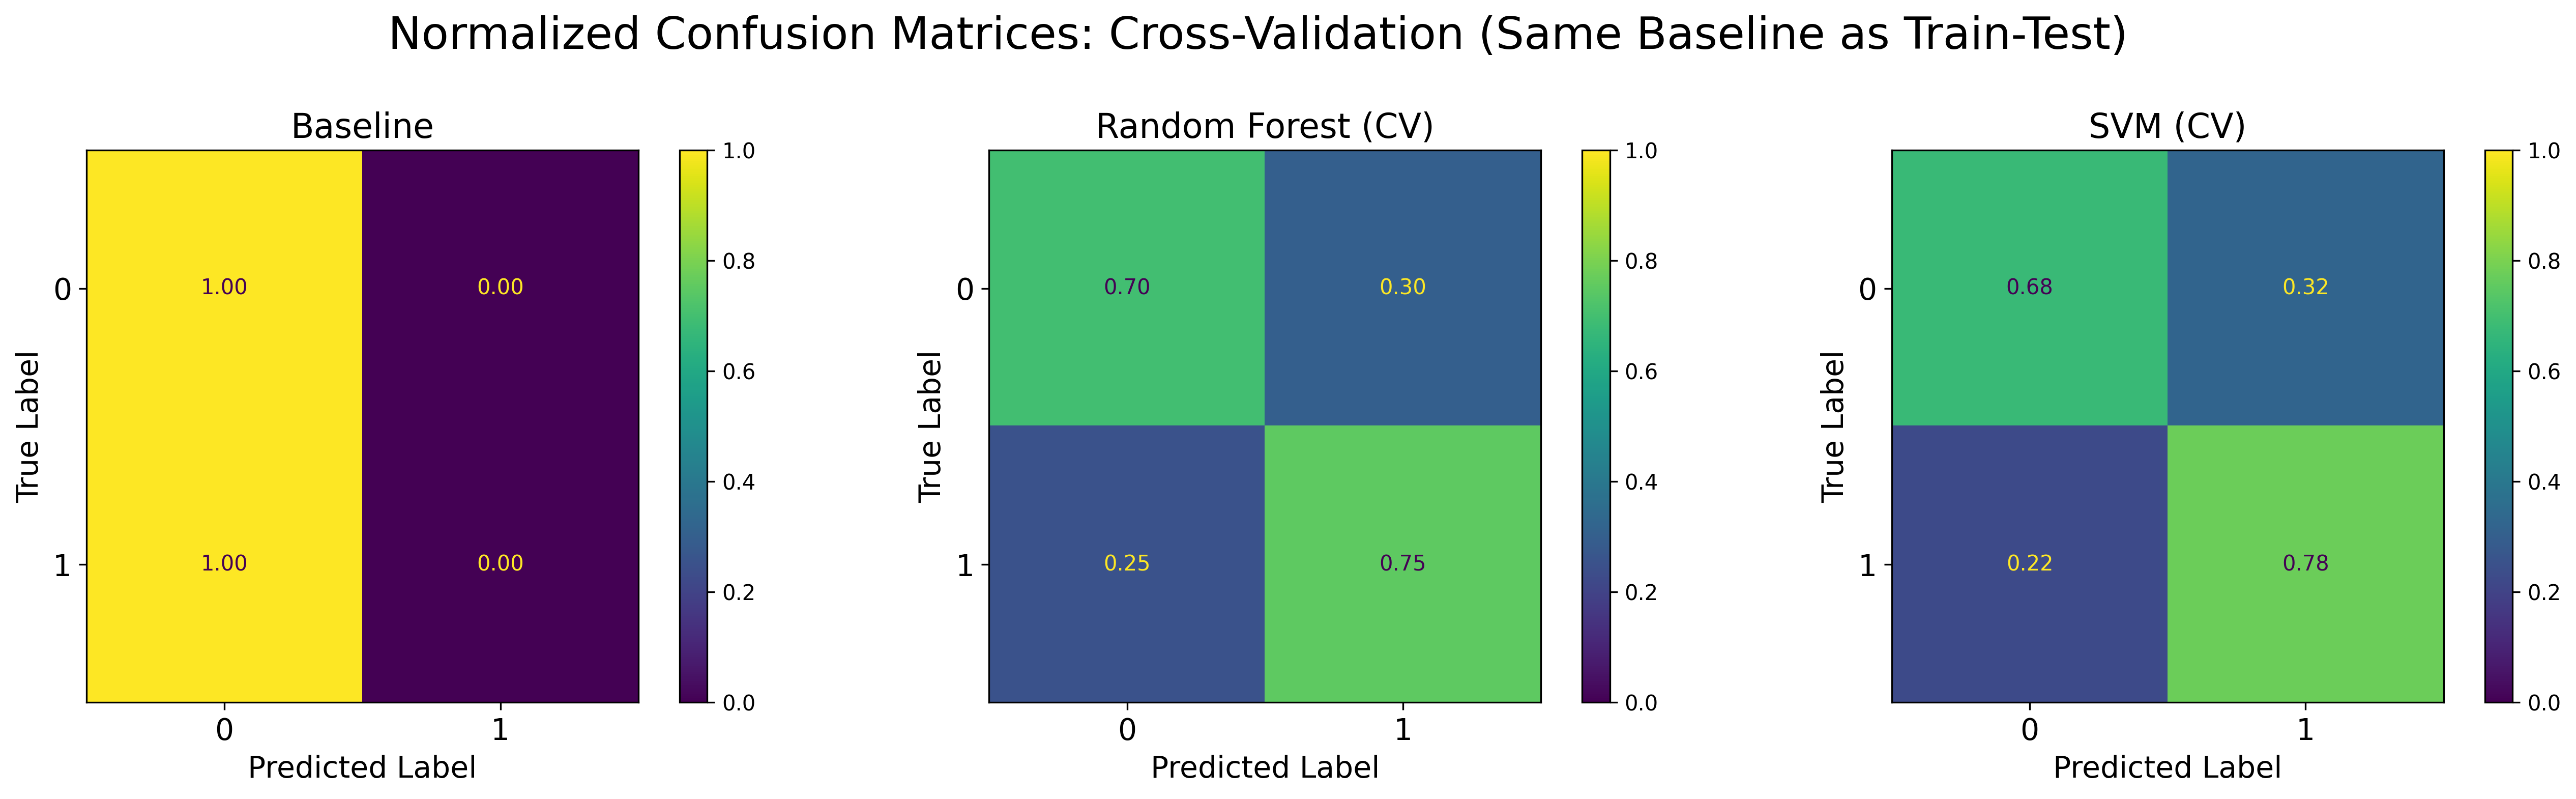

In [24]:
display(Image("plots/Confusion_Matrices_Simple.png"))
display(Image("plots/Confusion_Matrices_CV.png"))

$\Rightarrow$ In each matrix, the rounded recall score (2 decimals) is the value within the square in the bottom right. It is the rate of true positives to true positives + false negatives (sum of values within both bottom squares).

##### Finally, let's also show the comparison of ROC curves:

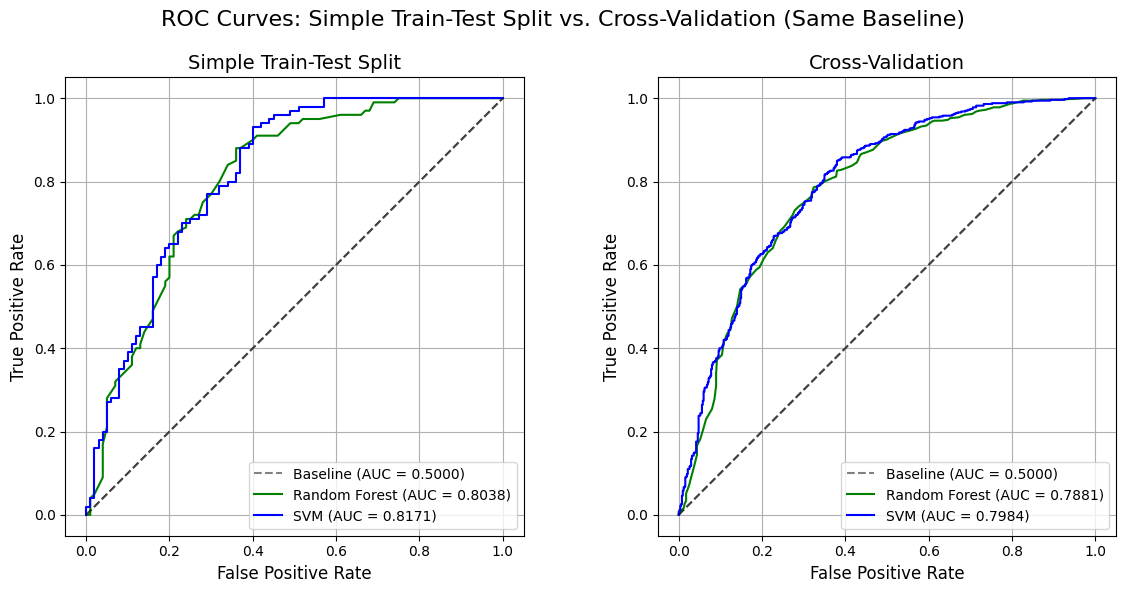

In [25]:
# Compute ROC curves for step 2 using out-of-fold proba predictions
# No need to compute the baseline again, as it is the same as in step 1
fpr_rf_cv, tpr_rf_cv, _ = roc_curve(y, y_proba_rf_all)
fpr_svm_cv, tpr_svm_cv, _ = roc_curve(y, y_proba_svm_all)

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("ROC Curves: Simple Train-Test Split vs. Cross-Validation (Same Baseline)", fontsize=16)

# Subplot 1 = Step 1: Simple Train-Test Split
axes[0].plot(fpr_base, tpr_base, label=f"Baseline (AUC = {roc_auc_baseline:.4f})", linestyle="--", color="gray")
axes[0].plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})", color="green")
axes[0].plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.4f})", color="blue")
axes[0].plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5)
axes[0].set_title("Simple Train-Test Split", fontsize=14)
axes[0].set_xlabel("False Positive Rate", fontsize=12)
axes[0].set_ylabel("True Positive Rate", fontsize=12)
axes[0].legend(loc="lower right", fontsize=10)
axes[0].grid(True)

# Subplot 2 = Step 2: Cross-Validation
axes[1].plot(fpr_base, tpr_base, label=f"Baseline (AUC = {roc_auc_baseline:.4f})", linestyle="--", color="gray")
axes[1].plot(fpr_rf_cv, tpr_rf_cv, label=f"Random Forest (AUC = {np.mean(roc_auc_rf_cv):.4f})", color="green")
axes[1].plot(fpr_svm_cv, tpr_svm_cv, label=f"SVM (AUC = {np.mean(roc_auc_svm_cv):.4f})", color="blue")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5)
axes[1].set_title("Cross-Validation", fontsize=14)
axes[1].set_xlabel("False Positive Rate", fontsize=12)
axes[1].set_ylabel("True Positive Rate", fontsize=12)
axes[1].legend(loc="lower right", fontsize=10)
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.99])
for ax in axes:
    ax.set_aspect("equal", adjustable="box") 
plt.show()

$\Rightarrow$ For CV both ROC curves increase a bit slower. This results in lower ROC AUC scores for both algorithms, as the area under the curve gets smaller with a slower increase.

### Interpretation: Simple Train-Test vs. Cross Validation Results

#### General Model Quality
- In the simple train-test setup as well as in the simple CV, both Random Forest and SVM outperform the baseline significantly in terms of **recall** and **ROC AUC** 
- In both cases **SVM** achieves highest recall and ROC AUC overall, making it the best-performing model in this experiment

#### Overfitting Check
- The similarity between initial and CV results suggests **little to no overfitting**:
  - Random Forest: Recall increases slightly from 0.72 → 0.75 in CV
  - SVM: Recall decreases slightly from 0.79 → 0.776 in CV
  - For both algorithms ROC AUC decrease by a low margin
- Generally, these results show that further tuning is needed, which will be done in the upcoming tasks

#### Stability of Results
- **Across evaluation setups**: The differences between the single test set results and the CV means are small. This suggests that the models perform consistently across different evaluation strategies, meaning that their performance is not overly dependent on a specific train-test split.
- **Within CV**: The standard deviations across the 10 folds are relatively high for random forest, indicating unstable performance for this algorithm. SVM shows a more stable performance across different subsets of the data, which could be a first indication that this algorithm might be the better choice.

### Conclusion
These experiments demonstrate that both models provide improvements over the baseline. The use of stratified 10-fold cross-validation shows that the scores of both models are getting better, with **SVM showing slightly better overall performance**. However, especially recall should be improved as it is critical in the context of diabetes detection.

## Task 6 - Hyperparameter Optimization – Nested Cross Validation

To improve model performance and better evaluate generalization, now **nested cross-validation** with **hyperparameter tuning** is applied to both models.

Nested CV consists of two loops:
- **Outer loop:** evaluates the model’s generalization performance
- **Inner loop:** performs hyperparameter optimization using `GridSearchCV`

This ensures that model selection does not bias the evaluation, avoiding overfitting on the validation set.

For this, **Pipelines** are used:
- They combine preprocessing (e.g., scaling) and model training
- This ensures transformations are applied correctly in every fold of the CV

The hyperparameter grids for the models are as follows:

- **Random Forest (A1)**:
  - `n_estimators`: Number of trees in the forest
  - `max_depth`: Maximum depth of each tree
  - `min_samples_split`: Minimum number of samples to split a node
  - `max_features`: Number of features considered at each split

- **SVM (A2)**:
  - `kernel`: Specifies the type of decision boundary function used by SVM
  - `C`: Controls trade-off between a smooth decision boundary and correctly classifying training points
  - `gamma`: Kernel coefficient, defines how far the influence of a single training example reaches

For all of this task 6 will be structured in four parts:
1. Setup of CVs, hyperaramter grids, and scoring metrics
2. Running experiments (with a helper function)
3. Showing the results
4. Interpretation/Evaluation and choice of final Model M

### 1. Setup of CVs, Hyperaramter Grids, and Scoring Metrics

In [26]:
# Outer CV: 10-fold, same as in task 5
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED) 

# Inner CV: for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED) 

# Defining random forest grid
rf_param_grid = {
    "clf__n_estimators": [10, 50, 100, 200],  
    "clf__max_depth": [None, 5, 10, 20],  # None = not limit the depth of the decision trees 
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],           
    "clf__max_features": ["sqrt", "log2"],   
    "clf__criterion": ["gini", "entropy"]
}

# Defining SVM grid
svm_param_grid = [
    {   # RBF kernel params
        "clf__kernel": ["rbf"],
        "clf__C": [0.001, 0.01, 0.1, 1, 10], 
        "clf__gamma": ["scale", 0.01, 0.1]
    },
    {   # Poly kernel params: separate to optimize runtime
        "clf__kernel": ["poly"],
        "clf__C": [0.001, 0.01, 0.1, 1, 10], 
        "clf__gamma": ["scale", 0.01, 0.1],
        "clf__degree": [2, 3, 4]
    }
]

# Scoring metrics
scoring = {
    "recall": "recall",
    "roc_auc": "roc_auc"
}

### 2. Running experiments (with a helper function)

**About the helper function**

Before executing the actual nested CVs for both algorithms, a helper function is defined in the following code cell. The function should handle the setup of the pipeline, contain the nested CV logic, and store the results in a structured way. By doing this we can run the two algorithms easily and keep the overview clean.

In this project, all model selection and hyperparameter tuning are performed with recall as the primary evaluation metric. This choice aligns with the domain goal of maximizing sensitivity in identifying individuals with (pre)diabetes.

The run_nested_cv function implements nested cross-validation, using an inner GridSearchCV with refit=`recall` to ensure that the final model selected in each fold is the one that performed best on recall during hyperparameter tuning. This makes recall the decisive factor in model selection.

Although ROC AUC is not used as the refit metric, it is still computed and reported for every fold. This allows for a comprehensive performance comparison while maintaining consistent model selection aligned to the goal.

This strategy avoids redundant training and preserves interpretability, while allowing ROC AUC to remain a useful secondary performance indicator across all evaluated models.

In [27]:
def run_nested_cv(X, y, estimator, param_grid, model_name, scale=False,
                  outer_cv=None, inner_cv=None, scoring=None, refit_metric="recall"):
    """
    Run nested cross-validation using a pipeline that may optionally include scaling.
    Performs hyperparameter tuning using GridSearchCV on the inner loop and evaluates performance on the outer loop.
    Tracks both recall- and ROC AUC-optimized parameter sets.

    Parameters:
    - X (pd.DataFrame): Feature matrix
    - y (pd.Series): Target vector
    - estimator (sklearn estimator): Base model (e.g., RandomForestClassifier)
    - param_grid (dict or list of dicts): Grid of hyperparameters (keys must match pipeline syntax)
    - model_name (str): Name of the model (used in result summaries)
    - scale (bool): Whether to include MinMaxScaler in the pipeline
    - outer_cv (CV splitter): Outer cross-validation strategy
    - inner_cv (CV splitter): Inner cross-validation strategy
    - scoring (dict): Scoring dictionary for GridSearchCV
    - refit_metric (str): Metric to refit the final estimator (default is "recall")

    Returns:
    - result (dict): {
        "mean_result": dict with overall mean and std of recall and ROC AUC across outer folds,
        "best_params_recall": list of best parameters per fold (based on recall, the refit metric),
        "per_fold_results": list of tuples (recall, ROC AUC, best_params_recall, model_name)
      }
    """
    # Build pipeline, depending on input parameters
    steps = []
    if scale:
        steps.append(("scaler", MinMaxScaler()))
    steps.append(("clf", estimator))
    pipeline = Pipeline(steps)

    # Grid search with inner CV
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=inner_cv,
                               scoring=scoring, refit=refit_metric, n_jobs=-1)

    # Nested CV using outer loop
    cv_results = cross_validate(grid_search, X, y, cv=outer_cv, scoring=scoring,
                                return_estimator=True, n_jobs=-1)

    # Collect mean results, extract best paramaters per outer fold, and assign it to the return dictionary
    mean_result = {"Model": model_name,
                   "Mean_Recall_Nest_CV": np.mean(cv_results["test_recall"]),
                   "Std_Recall_Nest_CV": np.std(cv_results["test_recall"]),
                   "Mean_ROC_AUC_Nest_CV": np.mean(cv_results["test_roc_auc"]),
                   "Std_ROC_AUC_Nest_CV": np.std(cv_results["test_roc_auc"])}
    
    best_params_list = [est.best_params_ for est in cv_results["estimator"]]

    # Pair recall and ROC AUC scores with corresponding best parameters
    per_fold_results = list(zip(cv_results["test_recall"],
                                cv_results["test_roc_auc"],
                                best_params_list,
                                [model_name] * len(best_params_list)))

    result = {"mean_result": mean_result, 
              "best_params": best_params_list,
              "per_fold_results": per_fold_results}

    return result

Now let's call the function for both algorithms:

In [28]:
# Run function for random forest and assign result to result_rf
result_rf = run_nested_cv(X, y, RandomForestClassifier(random_state=RANDOM_SEED),
                          rf_param_grid, model_name="Random Forest", scale=False,
                          outer_cv=outer_cv, inner_cv=inner_cv, scoring=scoring)

# Run function for SVM and assign result to result_svm
result_svm = run_nested_cv(X, y, SVC(probability=True, random_state=RANDOM_SEED),
                           svm_param_grid, model_name="SVM", scale=True,
                           outer_cv=outer_cv, inner_cv=inner_cv, scoring=scoring)

### 3. Showing the results

#### 3.1 Mean Model Performance (Nested Cross-Validation)

The following table shows the average performance of both models across all of their 10 outer folds during nested cross-validation:

In [29]:
# Combine results into a table and show it
nested_results = pd.DataFrame([result_rf["mean_result"], result_svm["mean_result"]]).round(4)
# Convert all numeric values to strings with 4 decimal places, including 0
nested_results = nested_results.map(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)
nested_results.set_index("Model", inplace=True)
nested_results

,Mean_Recall_Nest_CV,Std_Recall_Nest_CV,Mean_ROC_AUC_Nest_CV,Std_ROC_AUC_Nest_CV
Model,,,,
Random Forest,0.7680,0.0665,0.8008,0.0470
SVM,0.8280,0.0595,0.7833,0.0401


**Observations:**
- SVM achieved the highest average recall of 0.8280, which is a good score but probably not good enough in a medical context
- Random Forest showed a slightly higher average ROC AUC (0.8008), indicating good overall ranking
- Both models are not that consistent (so they are somewhat unstable), shown by relatively high standard deviations

#### 3.2 Best hyperparameters per fold

A table is created per algorithm. The respective table of the algorithm shows the best hyperparameter settings found in each of the 10 outer folds. These were selected based on inner-loop tuning for recall, as this evaluation metric is crucial in healthcare (as mentioned before).

In [30]:
# Random Forest: convert list of dicts to DataFrame
rf_params_df = pd.DataFrame(result_rf["best_params"])
rf_params_df.insert(0, "Fold", [f"Fold {i+1}" for i in range(len(rf_params_df))])
rf_params_df.replace({np.nan: "None"}, inplace=True)
rf_params_df.set_index("Fold", drop=True, inplace=True)

# SVM: convert list of dicts to DataFrame
svm_params_df = pd.DataFrame(result_svm["best_params"])
svm_params_df.insert(0, "Fold", [f"Fold {i+1}" for i in range(len(svm_params_df))])
svm_params_df.set_index("Fold", drop=True, inplace=True)

# Show results
print("Best Random Forest Parameters per Fold:")
display(rf_params_df)

print()

print("Best SVM Parameters per Fold:")
display(svm_params_df)

Best Random Forest Parameters per Fold:


,clf__criterion,clf__max_depth,clf__max_features,clf__min_samples_leaf,clf__min_samples_split,clf__n_estimators
Fold,,,,,,
Fold 1,entropy,5.0,sqrt,4,2,200
Fold 2,gini,None,sqrt,1,10,50
Fold 3,gini,None,sqrt,2,10,50
Fold 4,entropy,10.0,sqrt,4,10,200
Fold 5,entropy,10.0,sqrt,1,10,100
Fold 6,gini,5.0,sqrt,1,5,100
Fold 7,gini,None,sqrt,2,2,100
Fold 8,gini,None,sqrt,4,10,200
Fold 9,entropy,10.0,sqrt,1,2,50



Best SVM Parameters per Fold:


,clf__C,clf__gamma,clf__kernel
Fold,,,
Fold 1,0.100,scale,rbf
Fold 2,0.001,scale,rbf
Fold 3,0.001,scale,rbf
Fold 4,0.001,scale,rbf
Fold 5,0.100,scale,rbf
Fold 6,0.100,scale,rbf
Fold 7,0.001,scale,rbf
Fold 8,0.100,scale,rbf
Fold 9,0.100,scale,rbf


**Observations:**
- Random forest explored diverse settings, suggesting its performance is more sensitive to tuning
- SVM selected the same gamma `(scale)` and kernel `(rbf)` in every fold, while the `best C switched between 0.1 and 0.001` $\Rightarrow$ overall less diverse than random forest

#### 3.3 Best Individual Fold Results

These are the best single-fold results **across** both models and all folds, one optimized for highest recall, the other for highest ROC AUC. These represent the best performance achieved during evaluation.

In [31]:
# Combine folds from both models
all_folds = result_rf["per_fold_results"] + result_svm["per_fold_results"]

# Best by Recall
best_by_recall = max(all_folds, key=lambda x: x[0])
print("Best Recall:", f"{best_by_recall[0]:.4f}")
print("Algorithm:", best_by_recall[3])
print("Parameters:")
for k, v in best_by_recall[2].items():
    print(f"  {k}: {v}")

print()

# Best by ROC AUC
best_by_auc = max(all_folds, key=lambda x: x[1])
print("Best ROC AUC:", round(best_by_auc[1], 4))
print("Algorithm:", best_by_auc[3])
print("Parameters:")
for k, v in best_by_auc[2].items():
    print(f"  {k}: {v}")

Best Recall: 0.9400
Algorithm: SVM
Parameters:
  clf__C: 0.001
  clf__gamma: scale
  clf__kernel: rbf

Best ROC AUC: 0.8624
Algorithm: Random Forest
Parameters:
  clf__criterion: entropy
  clf__max_depth: 5
  clf__max_features: sqrt
  clf__min_samples_leaf: 4
  clf__min_samples_split: 2
  clf__n_estimators: 200


**Observations:**
- The best recall (0.9400) was achieved by SVM, supporting its role as the best detector of diabetic cases
- The best ROC AUC (0.8624) was achieved by Random Forest, showing its strength in class ranking
- So overall, both models demonstrated their respective potential in different areas

### 4. Interpretation/Evaluation and choice of final Model M

Let's have a look at the recall and ROC AUC scores of both algorithms, compared to task 5 (without standard deviations):

In [32]:
# Select relevant columns from each dataframe
simple_df = results_task5_df[["Recall_Train_Test", "Mean_Recall_CV",
                              "ROC_AUC_Train_Test", "Mean_ROC_AUC_CV"]]
nested_df = nested_results[["Mean_Recall_Nest_CV", "Mean_ROC_AUC_Nest_CV"]]

# Merge new dataframes based on index
final_df = pd.merge(simple_df, nested_df, left_index=True, right_index=True)

# Reorder columns: all recall first, then all ROC AUC
final_df = final_df[["Recall_Train_Test", "Mean_Recall_CV", "Mean_Recall_Nest_CV",
                     "ROC_AUC_Train_Test", "Mean_ROC_AUC_CV", "Mean_ROC_AUC_Nest_CV"]]
final_df

,Recall_Train_Test,Mean_Recall_CV,Mean_Recall_Nest_CV,ROC_AUC_Train_Test,Mean_ROC_AUC_CV,Mean_ROC_AUC_Nest_CV
Model,,,,,,
Random Forest,0.7200,0.7500,0.7680,0.8038,0.7881,0.8008
SVM,0.7900,0.7760,0.8280,0.8171,0.7984,0.7833


#### Comparison to Task 5 Results
Compared to the earlier simple train-test split and single cross-validation (task 5), the nested cross-validation generally yields slightly improved and more reliable estimates for both models:

- **Random Forest**:
  - Recall improved from 0.7500 (simple CV) → 0.7680
  - ROC AUC improved from 0.7881 (simple CV) → 0.8008
- **SVM**:
  - Recall improved from 0.7760 (simple CV) → 0.8280
  - ROC AUC decreased slightly from 0.7984 (simple CV) → 0.7833

**Generally:** Nested CV improves the recall scores of both algorithms in comparison to simple CV, as well as in comparison to the simple train-test split! However, both algorithms achieve the best ROC AUC scores in the simple train-test split! These changes confirm that nested CV led to moderate but meaningful gains just in recall, which was to be expected because `refit_metric="recall"` was used in GridSearchCV().

#### Stability and Variability
- The standard deviations are moderate to high for both models (≈ 0.04 – 0.07), indicating somewhat unstable results across folds
- In comparison to single CV, standard deviations even increased by a low margin
- SVM shows higher recall, but slightly lower ROC AUC than Random Forest
- Importantly, SVM’s best configuration was consistent across all folds, while Random Forest used a mix of parameter combinations, indicating that SVM's behavior is more stable when tuned

#### Best Single Fold Observations
- The best recall was achieved by SVM with 0.9400
- The best ROC AUC was achieved by Random Forest with 0.8748
- So both models may have high potential in specific folds, but SVM is more consistent with its parameters

#### Selection of Final Model M 
Given the **importance of recall** and the **consistent tuning result**, `SVM with RBF kernel, C = 0.001, and gamma = "scale"` is selected as the final model M.

This model will be used in the upcoming task 7 because it:
- Achieves the highest average recall (0.8280)
- Shows stable performance across folds
- Is interpretable in its configuration and benefits from consistent scaling

**$\Rightarrow$ As the final model M is important for task 7, the last step of the current task is saving the configuration of it for reuse. This is done in the following code cell:**

In [33]:
final_M = SVC(kernel="rbf", C=0.001, gamma="scale", probability=True, random_state=RANDOM_SEED)

#### **Important Note:**
The final model M selected here will be evaluated directly for performance in task 7 as the **baseline configuration (1. version)** in the ablation study.

## Task 7 - Feature Importance / Feature Ablation Study

### Feature Importance with Feature Permutation

This section focuses on analyzing which features contribute the most to the final model's predictive performance, which is done by using **permutation feature importance**. This method evaluates the decrease in model performance when the values of each feature are randomly shuffled, thus breaking their relationship with the target variable.

The final model M and the same outer 10-fold cross-validation from task 6 are picked, to ensure consistency in evaluation. The importance is measured by the mean decrease in recall, which is the primary metric. The results are plotted, to identify the most and least influential features.

This analysis forms the basis for the following ablation study, which evaluates how the removal of low-importance features affects performance.

For all of this task 7 will be structured in two parts:
1. Analyzing the most important features and plotting feature importances
2. Ablation study: different train-test-setups with varying features

### 1. Analyzing the most important features and plotting feature importances

To assess which features contribute most to the predictive performance of the final model M (SVM with RBF kernel), permutation-based feature importance is applied. Rather than computing importance from a single train-test split (which can lead to unstable or biased results), we **compute it across the same outer 10-fold cross-validation** used in task 6. This ensures:

- Robustness: Importance values are averaged over different data partitions
- Stability: Reduces the influence of chance from one specific split
- Consistency: Uses the same evaluation strategy as earlier tasks, making comparisons fair

The process:
1. For each feature, its values are randomly permuted while keeping all other features unchanged
2. The model's performance is re-evaluated on the permuted data
3. The performance drop indicates the importance of the feature: the larger the drop, the more important the feature
4. This is done for each fold and averaged across all 10 folds to reduce randomness and improve stability

The follwoing two code cells contain (1) a helper function to compute the feature importance via cross-validation, and (2) the execution of the function for the evaluation metrics:

In [34]:
def permutation_importance_cv(model, X, y, cv, metric, n_repeats=10):
    """
    Computes feature importances via permutation across cross-validation folds
    and returns both detailed fold-level results and summary statistics.

    Parameters:
        model (sklearn estimator or pipeline): The model or pipeline to evaluate.
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        cv (cross-validator): CV splitter (e.g., StratifiedKFold).
        metric (str): Scoring metric for importance (e.g., "recall", "roc_auc").
        n_repeats (int): Number of random permutations per feature (default: 10).

    Returns:
        fold_df (pd.DataFrame): Feature importances per CV fold (shape: [n_folds × n_features]).
        summary_df (pd.DataFrame): Summary with mean and std importance per feature.
    """

    fold_importances = []

    for train_idx, test_idx in cv.split(X, y):
        # Define a new pipeline in every iteration is safer against data leakage, than just defining it once outside the loop
        model_pipeline = Pipeline([("scaler", MinMaxScaler()),  
                                   ("clf", clone(model))  
                                   ])  
        # Define train and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train model on current fold
        model_pipeline.fit(X_train, y_train)  
 
        # Compute permutation importance on held-out fold
        result = permutation_importance(model_pipeline, X_test, y_test,       
                                        scoring=metric, n_repeats=n_repeats,
                                        random_state=RANDOM_SEED, n_jobs=-1)
        fold_importances.append(result.importances_mean)

    # Convert to dataframe: folds as rows and features as columns
    fold_importances_df = pd.DataFrame(fold_importances, columns=X.columns)

    # Compute summary statistics (mean and std) per feature
    importances_summary_df = fold_importances_df.mean().to_frame(f"Mean Importance {metric}")
    importances_summary_df[f"Std ({metric})"] = fold_importances_df.std()

    return fold_importances_df, importances_summary_df

In [35]:
# Compute feature permutation with CV for recall and ROC AUC
perm_recall_folds, perm_recall_summary = permutation_importance_cv(final_M, X, y, outer_cv, metric="recall")
perm_auc_folds, perm_auc_summary = permutation_importance_cv(final_M, X, y, outer_cv, metric="roc_auc")

# Combine summary results, to have them all in one table
# Note: results are just plotted for recall (perm_recall_summary)  
feature_importance_combined = pd.concat([perm_recall_summary, perm_auc_summary], axis=1)
feature_importance_combined.rename(columns={"Mean Importance recall":"Mean Importance Recall",
                                            "Mean Importance roc_auc":"Mean Importance ROC AUC",
                                            "Std (recall)":"Std Recall",
                                            "Std (roc_auc)":"Std ROC AUC"}, inplace=True)
feature_importance_combined.sort_values("Mean Importance Recall", ascending=True, inplace=True)
feature_importance_combined.reset_index(inplace=True)
feature_importance_combined.rename(columns={"index": "Feature"}, inplace=True)

Let's have a look at the feature importance values for recall. The table is sorted in descending order, so the highest values (most important features) are shown first:

In [36]:
# Select columns and sort
recall_importance_df = feature_importance_combined[["Feature", "Mean Importance Recall", "Std Recall"]] \
                            .sort_values(by="Mean Importance Recall", ascending=False).copy()

# Step 2: Format numeric columns
numeric_cols = ["Mean Importance Recall", "Std Recall"]
for col in numeric_cols:
    recall_importance_df[col] = recall_importance_df[col].apply(lambda x: f"{x:.4f}" 
                                                                    if abs(x) >= 1e-3 else f"{x:.1e}")
    
# Step 3: Reset index and show resulting dataframe 
recall_importance_df.set_index("Feature", drop=True, inplace=True)
recall_importance_df

,Mean Importance Recall,Std Recall
Feature,,
HighBP,0.0510,0.0311
HighChol,0.0222,0.0319
NoDocbcCost,0.0080,0.0171
Income,0.0046,0.0144
Age,0.0042,0.0175
AnyHealthcare,0.0034,0.0083
Veggies,0.0024,0.0122
Education,0.0020,0.0126
Sex,0.0010,0.0139


Now, let's **plot the mean feature importance over all 10 folds for recall** in a diagram via a horizontal error bar chart.

**Note:** If you would like to see the plot for ROC AUC, just replace `feature_importance_combined["Mean Importance Recall"]` with `feature_importance_combined["Mean Importance ROC AUC"]` in plt.errorbar().

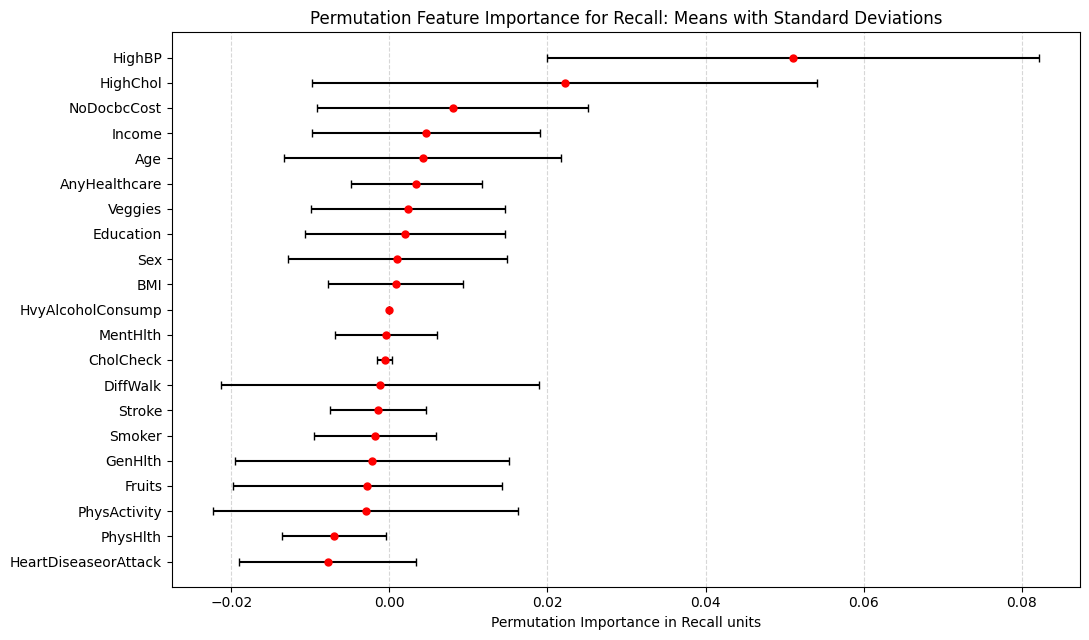

In [37]:
plt.figure(figsize=(11, 6.5))

plt.errorbar(feature_importance_combined["Mean Importance Recall"], # feature_importance_combined["Mean Importance ROC AUC"]
             feature_importance_combined["Feature"],
             xerr=feature_importance_combined["Std Recall"],
             fmt="o",        # points as mean values
             color="red",    # color of points (means)
             ecolor="black", # color of error bars (std)
             capsize=3,
             markersize=5,
             linestyle="none")

plt.xlabel("Permutation Importance in Recall units")
plt.title("Permutation Feature Importance for Recall: Means with Standard Deviations")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

#### Explanation of the Visualizationn

What each point represents:
Each red point shows the mean drop in recall when that feature’s values are shuffled:
- Rightward point (higher value) → shuffling the feature causes a big drop in performance → the feature is important
- Leftward point near zero, but still positive → shuffling had little effect → the model does not rely on it much
- Negative values → performance improved when shuffled → possibly a noisy or misleading feature

Error Bars:
The black horizontal lines from each point show the standard deviation of importance values across different CV folds:
- Short error bar → feature’s importance is stable and consistent across folds
- Long error bar →  importance is variable depending on the data split, indicating possible instability or interaction effects

Metric Units:
- Since the plot is based on recall, the values represent absolute changes in recall score (0–1 scale)
- These are not percentages, but raw differences in recall (e.g. 0.05 = a 5-point drop in recall)

#### Analysis and Discussion

##### Key Observations:

- **Most Important Feature**:

    `HighBP` (High Blood Pressure) stands out clearly as the most influential feature for recall. Shuffling this feature results in an average drop of ≈ 0.0510 in recall, the largest among all features. However, its standard deviation is high **compared to its mean**. This can be calculated by the coefficient of variation (CV), which is the standard deviation divided by the mean. In this case the coefficient of variation is ≈ 0.61, indicating unstable importance across folds. 

- **Other Noteworthy Features**:

    `HighChol` shows the second highest, and `NoDocbcCost` the third highest importance values. But it is important to mention that the scores themselves are not high and both coefficients of variation are above 1. This suggests that the contribution of both features is not that reliable and should not be overestimated. 

- **Near-Zero Importance**:

    Some features like `BMI`, `MentHlth`, and `CholCheck` have near-zero importance, `HvyAlcoholConsump` even is at zero. They also show very low variability, suggesting they have little to no impact on recall performance in this model.

- **Negative Importance**:

    Many features show a negative mean importance, which means that when they are shuffled, the model’s recall performance improves. However, as the negative values are small, the performance increase is not that significant. Generally, these features may be noisy, redundant, or even distracting the model.

##### Implications for Further Study:

This analysis is the basis for the following **ablation study**, where the model's performance with removed features is assessed. Based on the results above, the **two least important features** appear to be:
- `HeartDiseaseorAttack` (lowest mean importance = most negative one)
- `PhysHlth` (second lowest mean importance = second most negative one)

So the overall hypothesis is that removing either or both of these features will not hurt the recall score, given their behavior in the permutation analysis. Instead it may even improve the model's performance. These results also provide an understanding of feature reliability: features with high mean and low variance are strong candidates to retain, while those with low or unstable importance are candidates for removal or further investigation.

### 2. Ablation study: different train-test-setups with varying features

#### Important Note

When selecting the two least important features for this part, there are two ways to interpret "least important":

1. Features with **negative importance**, meaning that shuffling them improves performance: these may be harmful or misleading
2. Features with importance values **closest to zero** (minimal impact on performance)

This study uses the first interpretation, so selecting the two features with the **most negative mean permutation importance values:** `HeartDiseaseorAttack` (F1) and `PhysHlth` (F2). These features appear to negatively impact the model’s recall, so removing them may improve performance. This makes them good candidates for the analysis in the ablation study.

#### Study Setup

This part reuses the final model M (SVM with RBF kernel, C = 0.001, and gamma = 'scale') and the same outer 10-fold cross-validation as used in task 6. No further hyperparameter tuning is performed, the model configuration is fixed.

To evaluate the influence of these features, four versions of the dataset are created:

1. All features included (baseline)
2. All features excluding `HeartDiseaseorAttack` (F1)
3. All features excluding `PhysHlth` (F2)
4. All features excluding both `HeartDiseaseorAttack` and `PhysHlth` (F1 and F2)

Each setup is evaluated using cross-validation for both **recall** and **ROC AUC**, and the results are compared to the baseline performance. This helps assess whether removing low-importance features benefits or harms the model’s ability to detect positive cases.

To prepare for the ablation study, the four pipeline versions of the final model M are created. This is done with a helper function using ColumnTransformer to dynamically drop and scale columns within the pipeline. The SVM model and its hyperparameters remain the same:

In [38]:
def build_pipeline(features_to_drop, all_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ("dropper", "drop", features_to_drop), # Drop all columns listed in features_to_drop
            ("scaler", MinMaxScaler(), [col for col in all_features if col not in features_to_drop])
        ],
        remainder="drop" # IF any column(s) were not handled in one of the steps above, drop them (not the case here)
    )

    # Build the pipeline with final_M
    pipeline = Pipeline([("preprocess", preprocessor),
                         ("clf", final_M) 
                         ])

    return pipeline

In [39]:
# Using the helper function to define the 4 versions to evaluate
ablation_pipelines = {"Keep all Features": build_pipeline([], X.columns),  # Do not drop any feature
                      "Drop F1": build_pipeline(["HeartDiseaseorAttack"], X.columns), # Drop F1
                      "Drop F2": build_pipeline(["PhysHlth"], X.columns),             # Drop F2
                      "Drop F1 and F2": build_pipeline(["HeartDiseaseorAttack", "PhysHlth"], X.columns)} # Drop F1 and F2

Now, each of the four pipeline configurations is evaluated using stratified cross-validation. The performance is measured using the two key metrics: recall and ROC AUC. The results are aggregated across folds to compare the impact of removing F1 and or F2:

In [40]:
# Define scoring
scoring = {"recall": "recall",
           "roc_auc": "roc_auc"}

# Evaluate each ablation pipeline
ablation_results = []

for name, pipeline in ablation_pipelines.items():
    scores = cross_validate(estimator=pipeline,
                            X=X,  
                            y=y,  
                            scoring=scoring,
                            cv=outer_cv,
                            return_train_score=False,
                            n_jobs=-1)

    ablation_results.append({"Setup": name,
                             "Mean Recall": round(np.mean(scores["test_recall"]), 4),
                             "Std Recall": round(np.std(scores["test_recall"]), 4),
                             "Mean ROC AUC": round(np.mean(scores["test_roc_auc"]), 4),
                             "Std ROC AUC": round(np.std(scores["test_roc_auc"]), 4)
                              })

# Convert results to DataFrame
ablation_df = pd.DataFrame(ablation_results).map(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)
print("F1 = HeartDiseaseorAttack | F2 = PhysHlth")
ablation_df

F1 = HeartDiseaseorAttack | F2 = PhysHlth


,Setup,Mean Recall,Std Recall,Mean ROC AUC,Std ROC AUC
0,Keep all Features,0.8240,0.0578,0.7762,0.0372
1,Drop F1,0.8280,0.0560,0.7757,0.0377
2,Drop F2,0.8200,0.0600,0.7770,0.0371
3,Drop F1 and F2,0.8240,0.0445,0.7753,0.0366


#### Discussion of Ablation Study Results

The ablation study aimed to evaluate the effect of removing the two least important features (`HeartDiseaseorAttack` and `PhysHlth`) as identified in the feature importance analysis.

##### Key Observations:

- **Recall remains basically unchanged** across all setups, with a slight increase when F1 is removed
- **The same can be said about ROC AUC**, however the slight increase occurs when F2 is removed
- The **combined removal** does not change the recall score, and **decreases ROC AUC** by a very low margin
- The standard deviations are relatively high for recall and moderate for ROC AUC, so the results are not that stable

##### Comparison to Feature Importance Study:

These results are in line with the previous permutation importance analysis:
- Both `HeartDiseaseorAttack ` and `PhysHlth` had **negative importance scores**, meaning that permuting them led to a slight increase in recall
- Their removal was expected to have little or no negative effect, which is confirmed here
- This outcome supports the idea that these features may be noisy or unhelpful in the context of this model and the main metric (recall)

##### Conclusion:

The results indicate that **the final model M is robust and does not improve** by removing these two features. Leaving either one of them out does not change the overall performance that much and even decreases ROC AUC if both are removed. Also, there is no clear pattern that indicates when performances increases or decreases: dropping F1 increases recall but decreases ROC AUC, and dropping F2 decreases recall but increases ROC AUC.

## Task 8 - Conclusions and Future Work

This part concludes the project and summarizes its most important aspects. The results are discussed in the context of identifying individuals with (pre)diabetes. Furthermore, ideas for future work that may improve this study are proposed. As no study is perfect, the weaknesses and pitfalls are also highlighted, so they can be addressed or avoided in future research.

### 8.1 Summary and Interpretation of Results

Throughout the project, various models were evaluated to classify individuals as having either no diabetes or prediabetes/diabetes, based on a wide range of health indicators.

The final selected model (SVM with RBF kernel, C = 0.1, gamma = 'scale') achieved an average recall score of 0.8220 and an average ROC AUC score of 0.7868 in nested cross-validation. In the beginning a simple baseline (DummyClassifier) was defined, which achieves a recall 0 and a ROC AUC of 0.5. Therefore it's obvious, tha the model outperformes the baseline by far for both evaluation metrics. This is good, and in general someone might consider the achieved scores as acceptable to solid results. However, in the case of detecting people with (pre)diabetes both scores might not be good enough.

The feature importance study using permutation importance revealed that HighBP, HighChol, and NoDocbcCost were the most influential features. For HighBP it is not surprising, as with high blood pressure the risk of diabetes rises. Also high cholesterol levels are associated with insulin resistance, which can be a key factor in developing type 2 diabetes. NoDocbcCost might be an important social factor here, as it tells whether someone was not able to see a doctor due to cost in the past 12 months. This indicates that the model considers no access to medical care due to cost-related barriers to be a key signal in distinguishing individuals with or without (pre)diabetes. However, as the importance value was not that high for NoDocbcCost, this should not be overestimated.

HeartDiseaseorAttack and PhysHlth were the least important features and were selected for removal in the ablation study. This is understandable because diabates is an important factor for the risk of medical heart issues (CHD or MI) **but not vice versa**. Also, PhysHlth was measured by asking people the number of days their physical health was not good out of the past 30 days. This is highly subjective and there is no definition what a good or bad physical health is. 

In the ablation study, removing either HeartDiseaseorAttack, PhysHlth, or both did not led to significant changes in model performance, confirming the reliability of the feature importance findings and suggesting some redundancy or irrelevance in the excluded variables. These results indicate that the selected model is both robust and somewhat generalizable.

### 8.2 Generated Value

The developed machine learning model contributes concrete value in the context of public health and early detection of diabetes and prediabetes. Several key aspects illustrate this:

- **Focus on Recall**

    Prioritizing recall ensures that individuals at risk are not overlooked. This is crucial for diabetes, a condition that often remains undiagnosed until complications arise. By minimizing false negatives, the model aligns with preventive healthcare goals.

- **Low-Resource Applicability**
    
    The model was built on a limited, balanced subset of 1,000 instances, demonstrating that effective predictions can be achieved even in smaller or resource-constrained settings, such as regional health campaigns or mobile screening programs.

- **Model Design**

    The pipeline integrates clear preprocessing, model selection, and evaluation steps, making it reproducible and available for further studies. Professionals in the health sector as well as patients can understand how predictions are made, increasing trust and usability.

- **Feature Insights**

    The feature importance analysis provides insights into which health indicators are most predictive (e.g., high blood pressure, high cholesterol), supporting health education and targeted awareness campaigns.

- **Ablation Study**

    The ablation study confirmed that overall the model is robust and stable to noisy or weak features, which strengthens its reliability when deployed in real-world scenarios where data quality may vary.

Together, these contributions show how this project not just focused on model performance. Instead it offers a practical tool for early diabetes risk detection and supports informed decision-making in healthcare settings. However, of course this study is far away from being perfect. So the next 2 parts will propose ideas for future work, as well as discussing the pitfalls and issues of this study.

### 8.3 Proposals for Future Work

To build upon the insights gained in this study and address current limitations, the following ideas for future work are proposed:

- **Including More Objective and Measured Features**
    
    Many of the features in the current dataset are self-reported (e.g. GenHlth, MentHlth, PhysHlth), which can lead to inaccurate predictions. Future studies should use measured and clinical variables, such as actual blood pressure readings, detailed biometric data, and other clinical indicators. Most importantly, the dataset lacks any feature related to **blood glucose levels**, which can be a main factor for a person developing diabetes. Including such measured values could improve both the accuracy and reliability of the model in real-world applications.

- **Including Additional Non-Binary Features**

    Most variables in the dataset were binary. Future versions of the dataset might include more detailed continuous or ordinal features (e.g., blood sugar levels, blood pressure readings, or physical activity in minutes), which could improve the model and enable better classification results.

- **Using Gradient Boosting Methods**

    Algorithms like XGBoost or LightGBM may outperform SVM or Random Forest in tabular data with complex interactions. Their ability to model non-linear patterns while handling feature importance internally could bring measurable performance gains.

- **Implementing Cost-Sensitive Learning**

    Given the high impact of false negatives in diabetes detection, models that explicitly penalize false negatives (e.g., by modifying class weights or using cost-sensitive loss functions) could further improve recall.

- **Deploying on Real-World Data Streams**

    Evaluating the model on real-time data or new population subsets could validate generalizability. This might involve testing with regional health surveys or electronic health records where missing or noisy data is more prevalent.

- **Interactive Feature Selection**

    Based on the permutation importance results, feature selection could be automated using threshold-based filtering. Combining this with domain expertise (e.g., from clinicians) could lead to a hybrid data-driven and expert-informed model design.

### 8.4 Evaluation and Reviw of the chosen Methodology

This section evaluates the overall methodology used in this project, its limitations, and what could have been done differently in hindsight.

#### Strengths of the Methodology

- **Systematic Evaluation Pipeline**

    The workflow followed a clearly structured sequence: baseline establishment, model selection, cross-validation, hyperparameter tuning, feature importance analysis, and ablation study. This ensured rigorous, reproducible results.

- **Selected Evaluation Metrics**

    Recall and ROC AUC were chosen based on the task’s healthcare relevance. Prioritizing recall was consistent throughout the pipeline, reflecting the importance of detecting as many (pre)diabetes cases as possible.

- **Nested Cross-Validation and Model Transparency**
    
    Implementing nested CV avoided data leakage during hyperparameter tuning, which adds credibility and generalizability to the model performance estimates. Feature importance and ablation studies increased the transparency of model decisions and added interpretability, which is essential in sensitive domains like healthcare.

#### Limitations and Pitfalls

- **Dependence on Self-Reported Data**

    Most features were derived from survey questions (e.g., self-rated health, physical activity), which introduces subjective bias and measurement noise. Objective, clinically measured features would have improved reliability.

- **Binary Feature Encoding Reduces Expressiveness**

    Many features are binary, so more granular ordinal or continuous formats could add more information for the models.

- **Single Dataset Evaluation**

    All analysis was limited to one dataset. Additional datasets could reveal how robust the final model is across populations.

- **No Consideration of Feature Interactions**
    
    Although random forest and SVM can capture interactions to some extent, no explicit effort was made to analyze or engineer feature interactions or combinations (e.g. Age × Activity).

#### In Hindsight

- It may have been helpful to start with more flexible data exploration before locking in binarized features
- A stronger focus on model interpretability would enhance applicability of the model in healtcare
- The goal of building a model that distinguishes people with or without (pre)diabetes is ambitious but achievable, even if the current results show that further improvements need to be done for real-world application
- However, more domain knowledge might be needed to refine feature selection and to improve the evaluation strategy further, thus helping to achieve higher scores in the selected evaluation metrics